# REVIEWS

### Sentiment Analysis

Objectif : prédire si un commentaire est positif ou négatif

Type : Classification

Piste de travail : 

- définir les commentaires négatifs ou positifs (note > seuil)
- identifier les mots les plus présents dans chacun des types de sentiments
- faire un modèle à la main en calculant un score de négativité
- approche bag of words
    
    
Lien : https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/reviews.csv

### Description des données

Colonnes :

- Rating : note sur 5

- Year_Month : mois du commentaire

- Reviewer_Location : Pays d'origine du commentaire

- Review_Text : contenu du commentaire

### Imports et lecture du DataFrame

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.core.display import display, HTML
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.tokenize.treebank import TreebankWordDetokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#affichage large
display(HTML("<style> *{margin:0; padding:0;} html, body, \
             .container{margin:2;!important padding:0;!important} \
             .container { width:100% !important;}</style>"))

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv("https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/reviews.csv")
df.head(5)

Rating Year_Month     Reviewer_Location  \
0       5     2019-3  United Arab Emirates   
1       4     2018-6        United Kingdom   
2       5     2019-4        United Kingdom   
3       4     2019-4             Australia   
4       5    missing                France   

                                         Review_Text  
0  We've been to Disneyland Hongkong and Tokyo, s...  
1  I went to Disneyland Paris in April 2018 on Ea...  
2  What a fantastic place, the queues were decent...  
3  We didn't realise it was school holidays when ...  
4  A Trip to Disney makes you all warm and fuzzy ...

### Analyse des données

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13630 entries, 0 to 13629
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             13630 non-null  int64 
 1   Year_Month         13630 non-null  object
 2   Reviewer_Location  13630 non-null  object
 3   Review_Text        13630 non-null  object
dtypes: int64(1), object(3)
memory usage: 426.1+ KB


A ce stade, le jeu de données semble complet :

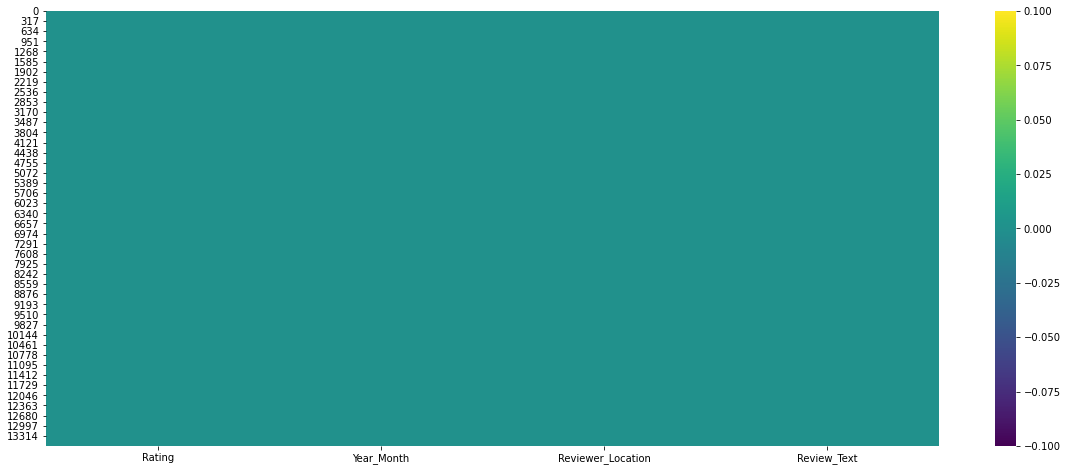

In [6]:
plt.figure(figsize=(20,8))
sns.heatmap(df.isnull(),cmap='viridis');

             Rating
count  13630.000000
mean       3.960088
std        1.205324
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000


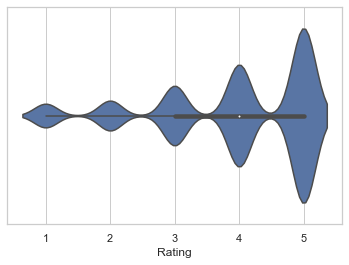

In [7]:
sns.set_theme(style="whitegrid")
print(df.describe())
ax = sns.violinplot(x=df["Rating"])

Il y a de plus en plus d'avis à mesure que l'on monte dans la notation.

La notation moyenne est de 4/5

In [8]:
min_date = df['Year_Month'].value_counts().sort_index().keys()[0]
max_date = df['Year_Month'].value_counts().sort_index().keys()[-2]

print('min date :', min_date)
print('max date :', max_date)

min date : 2010-10
max date : 2019-4


La période sur laquelle ont été recueilli les avis s'étale d'octobre 2010 à avril 2019



==> Rating :


counts     %
5    6111  44.8
4    3564  26.1
3    2083  15.3
2    1044   7.7
1     828   6.1

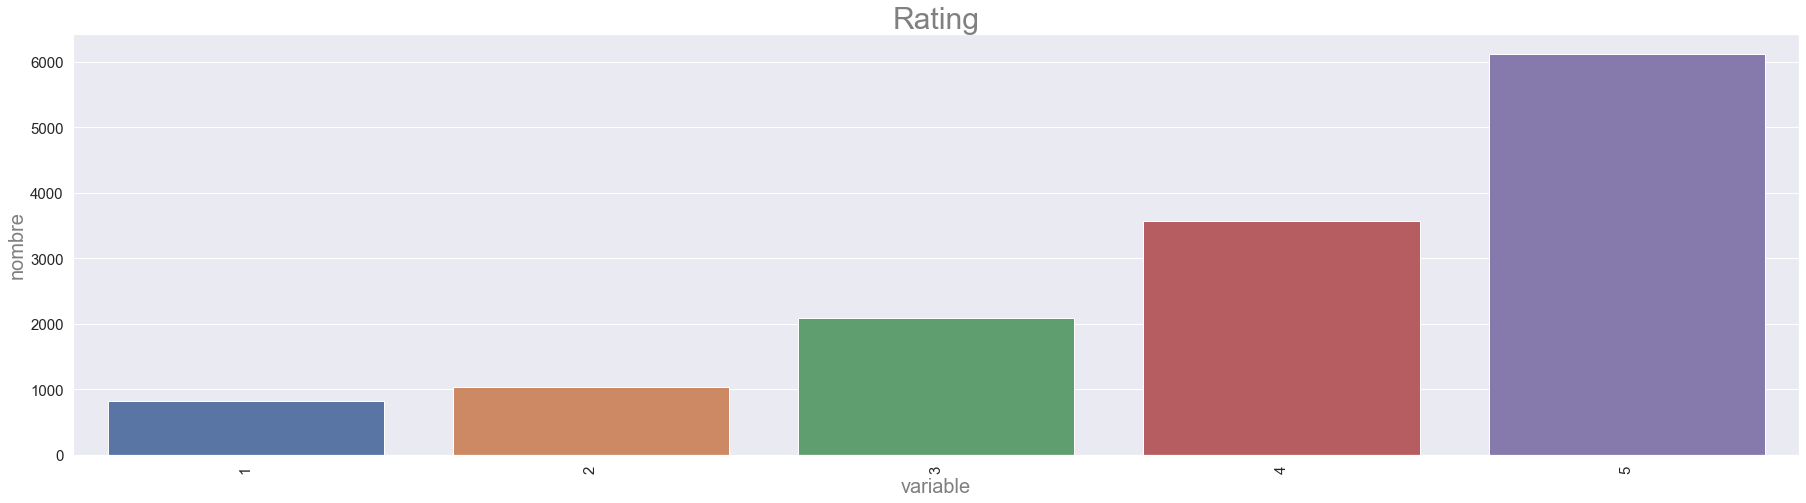



==> Year_Month :


counts    %
missing     936  6.9
2015-8      331  2.4
2015-7      278  2.0
2014-8      244  1.8
2013-8      229  1.7
...         ...  ...
2010-7        3  0.0
2010-6        3  0.0
2010-8        2  0.0
2010-5        1  0.0
2010-3        1  0.0

[110 rows x 2 columns]

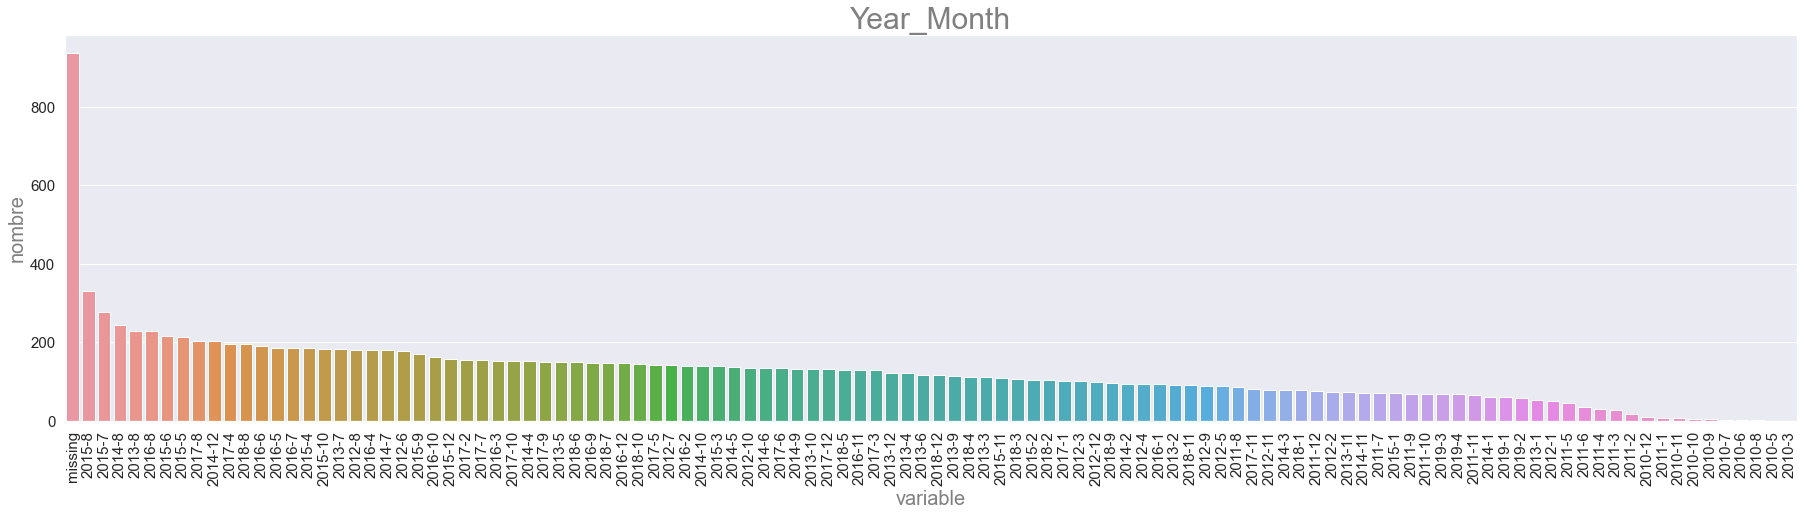



==> Reviewer_Location :


counts     %
United Kingdom    7992  58.6
United States     1331   9.8
Australia          595   4.4
Ireland            430   3.2
India              293   2.1
...                ...   ...
Venezuela            1   0.0
Guatemala            1   0.0
Bolivia              1   0.0
Brunei               1   0.0
Laos                 1   0.0

[133 rows x 2 columns]

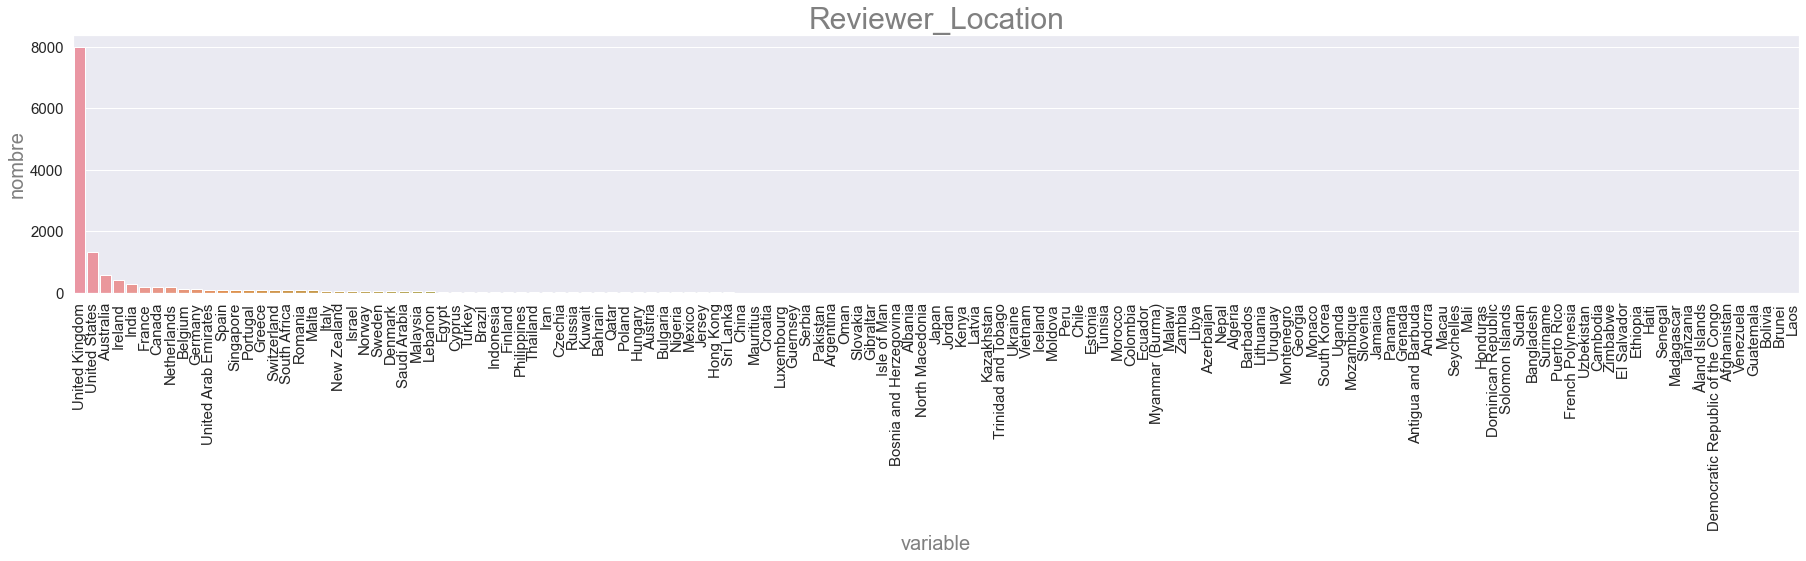

In [9]:
col_list = ['Rating', 'Year_Month', 'Reviewer_Location']

for col in col_list:
    val = df[col].value_counts(dropna=False)
    perc = round(df[col].value_counts(dropna=False, normalize=True)*100,1)
    print('\n\n==>', str(col), ':')
    counts_tab = pd.concat([val, perc], axis=1, keys=['counts', '%'])
    display(counts_tab)

#     counts_tab.reset_index().iloc[:,0]
    fig = plt.figure(1, figsize=(25, 7))
    sns.set_style('darkgrid', {'legend.frameon':True})
    b = sns.barplot(x = counts_tab.reset_index().iloc[:,0], y = counts_tab.reset_index().iloc[:,1]);
    b.axes.set_title(col,fontsize=30, color='grey')
#     b.set_xticklabels(xticklabels, rotation = 45, ha="right")
    plt.xticks(rotation=90)
    plt.tight_layout()
    b.set_xlabel("variable",fontsize=20, color='grey')
    b.set_ylabel("nombre",fontsize=20, color='grey')
    b.tick_params(labelsize=15)
    plt.show()

Observations :
- les spectateurs presentent a priori un biais positif (plus la notation est élevée, plus on compte d'avis)
- les mois de l'année qui comptent le plus d'avis (plus de retour spectateurs ? plus de fréquentation des salles ? plus de sorties de films ?) sont les mois de mai à août. Ceux qui en comptent le moins s'étalent d'octobre à février (circa)
- le pays le plus représenté dans l'échantillon est l'UK (60%) suivi des US (10%)

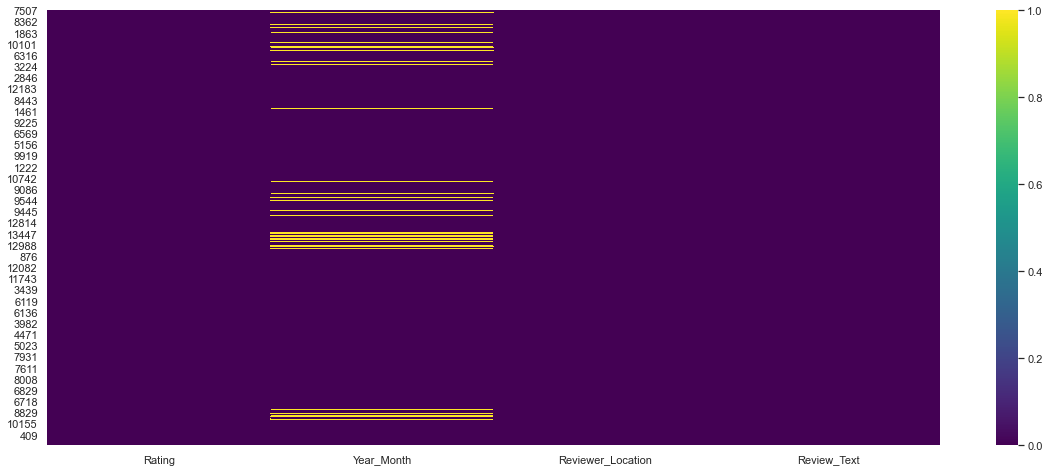

In [10]:
dg = df.replace('missing', np.NaN)
dg = dg.sort_values('Reviewer_Location')
plt.figure(figsize=(20,8))
sns.heatmap(dg.isna(),cmap='viridis');

On remarque qu'il y a des valeurs manquantes.

Elles sont regroupées sous le label 'missing', et ne concernent que les dates de review.

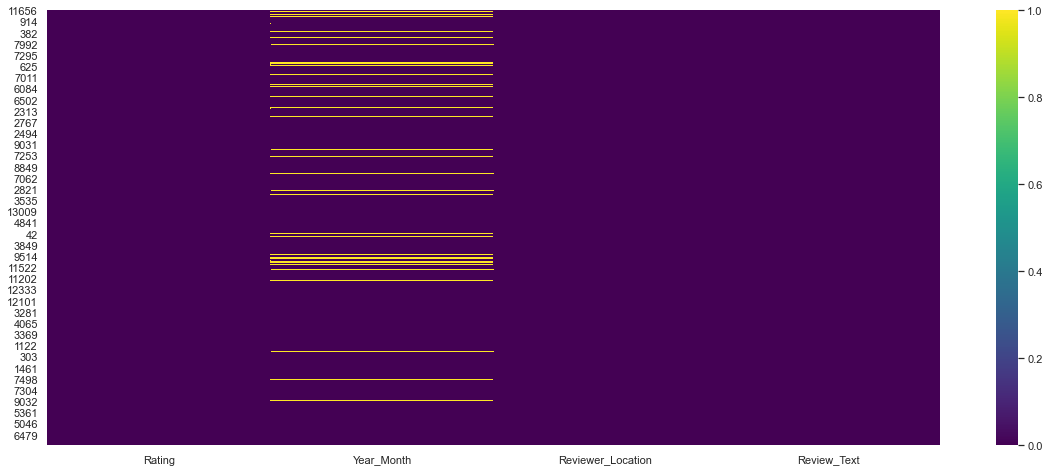

In [11]:
dg = df.replace('missing', np.NaN)
dg = dg.sort_values('Rating')
plt.figure(figsize=(20,8))
sns.heatmap(dg.isna(),cmap='viridis');

On n'observe a priori pas de corrélation particulière entre les valeurs manquantes et le pays de la review, ou la notation.

##### Wordcloud par notation (brut) :

Rating: 1


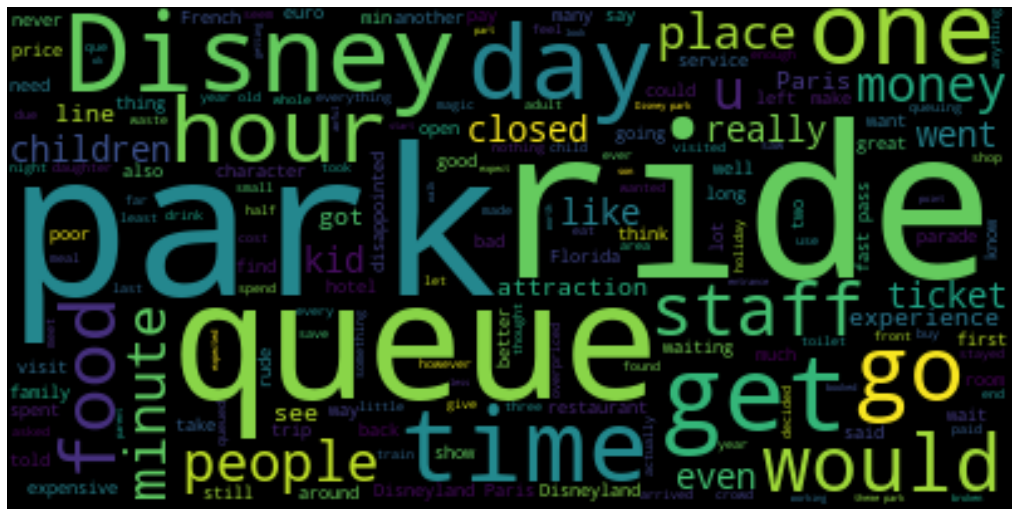

Rating: 2


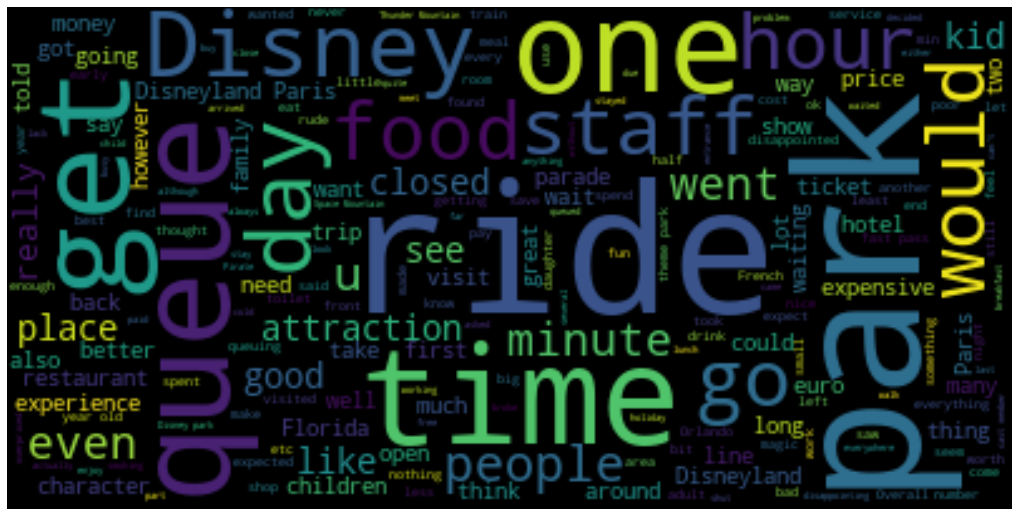

Rating: 3


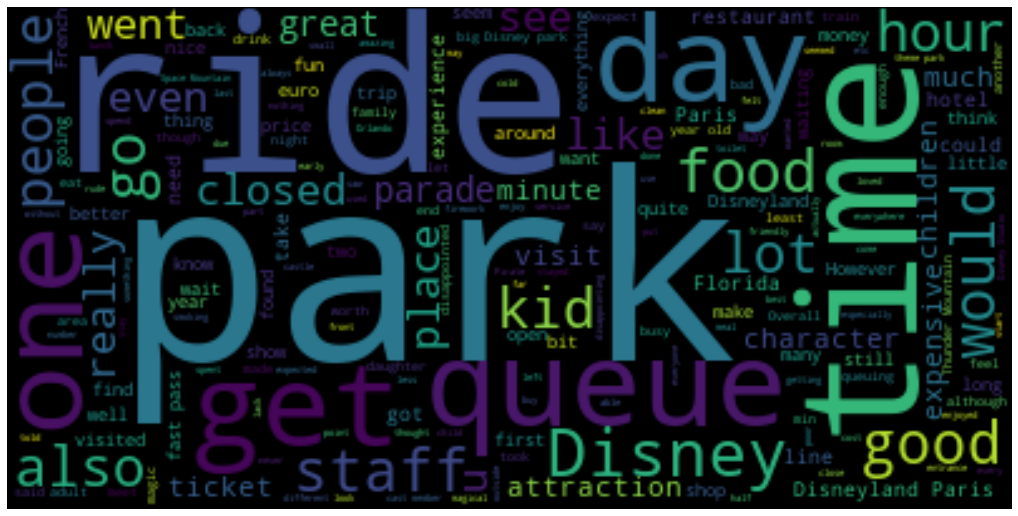

Rating: 4


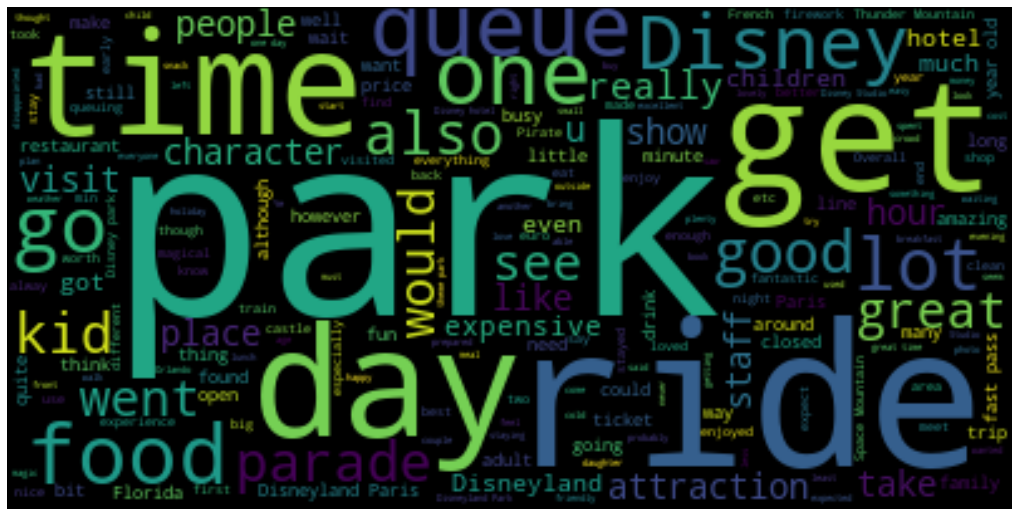

Rating: 5


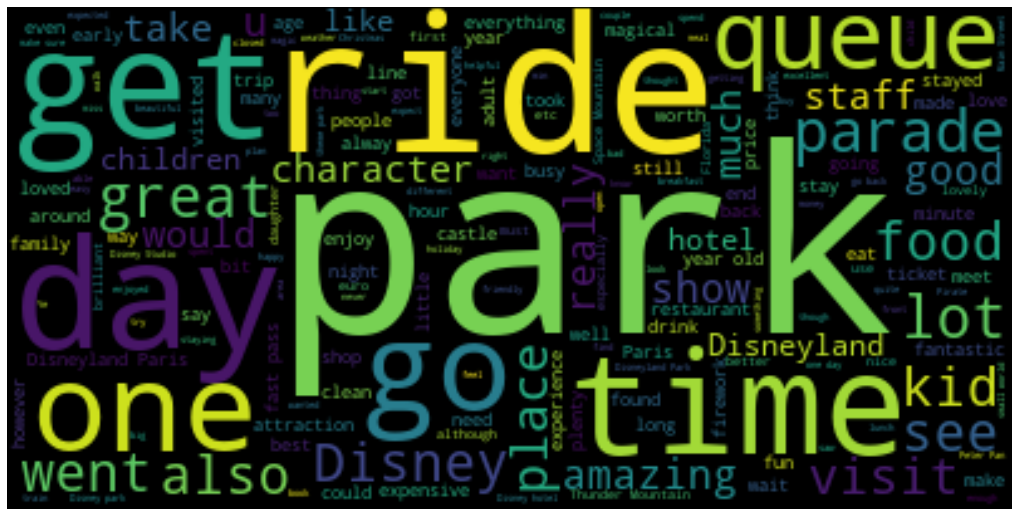

In [12]:
# Create stopword list:
stopwords = set(stopwords.words("english"))
Review_Text = {}
textt1 = {}
for i in range(1,6):
    plt.rcParams['figure.figsize'] = (18, 10)
    print("Rating:", i)
    Review_Text[i] = df.Review_Text.loc[df['Rating']==i]
    textt1[i] = " ".join(review for review in Review_Text[i])
    wordcloud = WordCloud(stopwords=stopwords).generate(textt1[i])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

On détecte des mots fréquemment employé dans le corpus, et présents sur l'ensemble des notations.

On va considérer que ces mots font partie du vocabulaire commun du corpus et qu'ils n'apportent ainsi aucune information intéressante pour notre classification. 

C'est le cas par exemple pour les mots "park", "ride", "rides", "day", "get", "time", "Disney", "Disneyland", "One", "queue", "go", "food", "Paris".

Lorsqu'on les retraite, on s'aperçoit que l'on obtient des wordcloud par notation bien plus cohérents. Il faut donc en tenir compte dans la modélisation.

##### Wordcloud par notation (après retraitement de certains mots récurrents) :

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Rating: 1


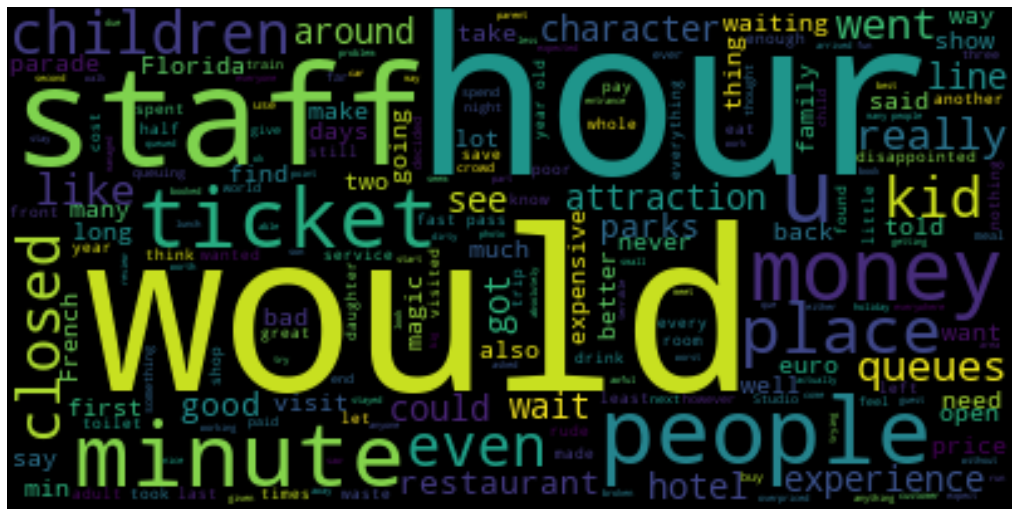

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Rating: 2


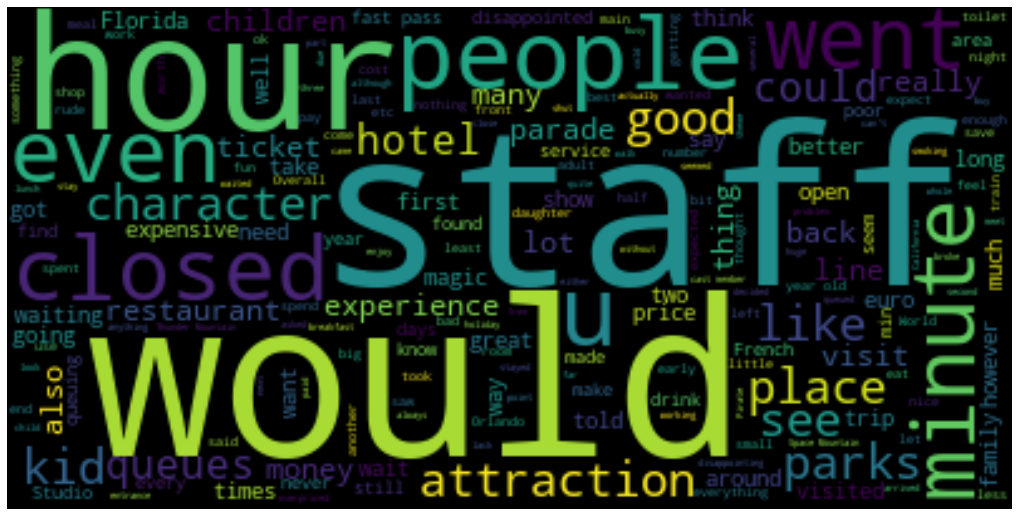

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Rating: 3


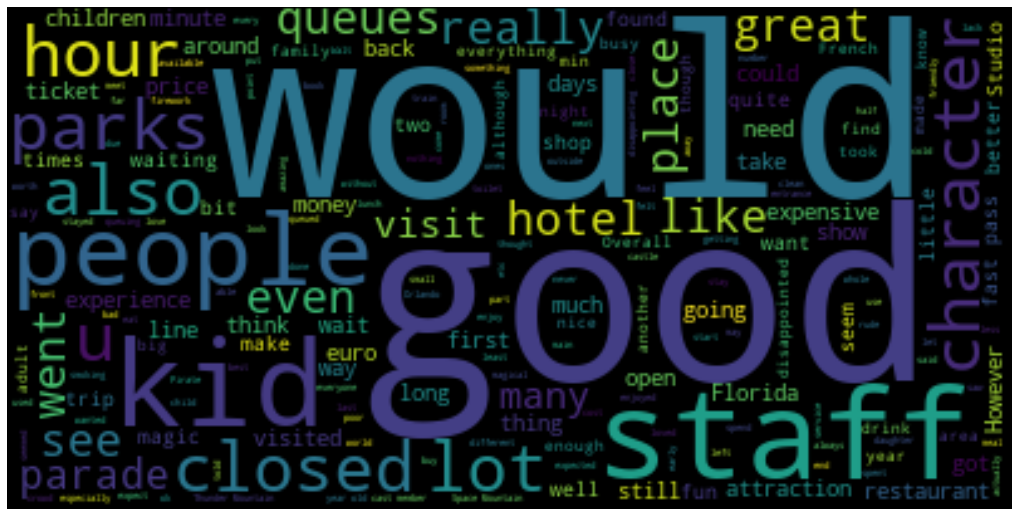

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Rating: 4


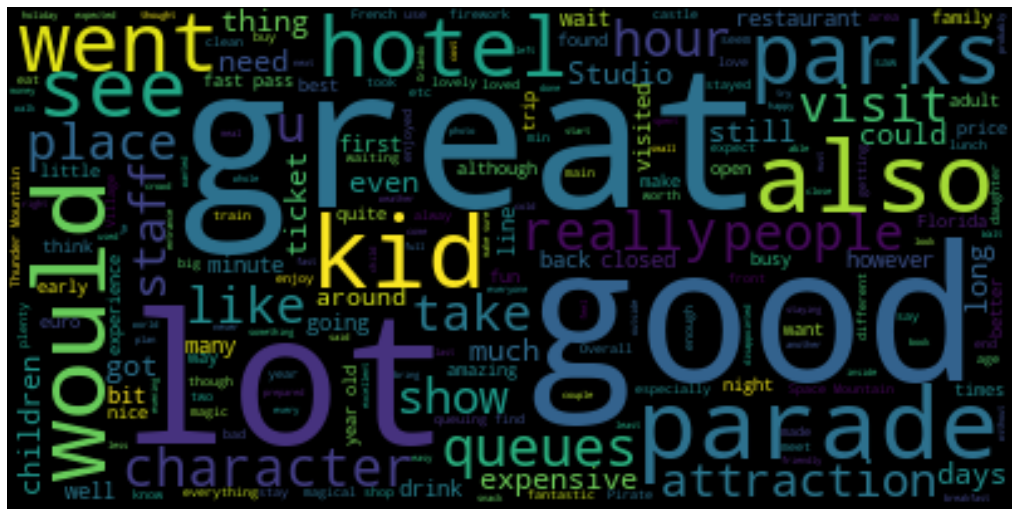

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Rating: 5


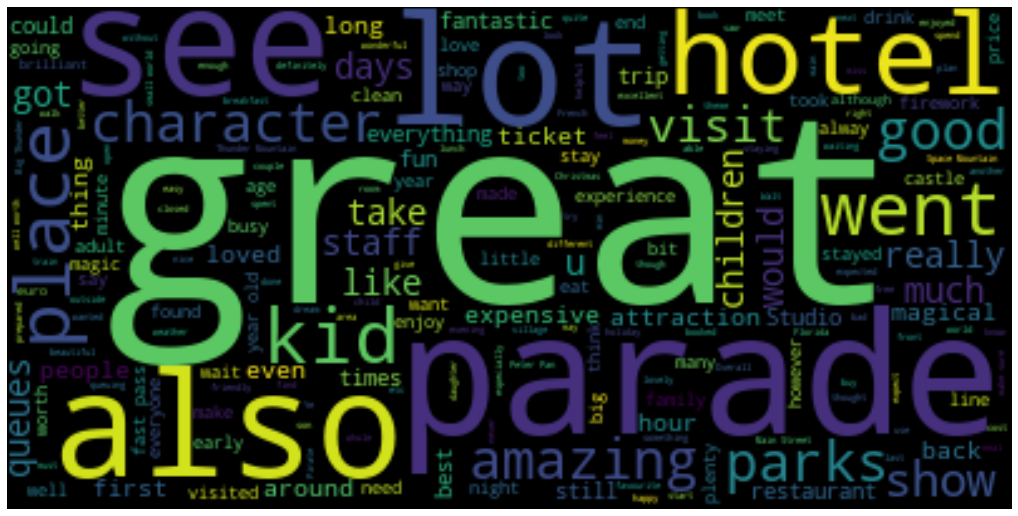

In [13]:
Review_Text = {}
textt2 = {}
for i in range(1,6):
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    stopwords = set(stopwords.words("english"))
    stopwords.update(["park", "ride", "rides", "day", "get", "time", "Disney", "Disneyland", "One", "queue", "go", "food", "Paris"])
    plt.rcParams['figure.figsize'] = (18, 10)
    print("Rating:", i)
    Review_Text[i] = df.Review_Text.loc[df['Rating']==i]
    textt2[i] = " ".join(review for review in Review_Text[i])
    wordcloud = WordCloud(stopwords=stopwords).generate(textt2[i])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Les Wordcloud sont plus pertinents parès retraitement.

In [14]:
# dico_avis = {}
# dico_words = {}
# for i in range(1,6):
#     dico_avis[i] = WordCloud().process_text(textt[i])
#     dico_words[i] = {k: v for k, v in sorted(dico_avis[i].items(), key=lambda item: item[1], reverse=True)}

### Classification des avis

Les avis négatifs, c'est à dire ceux qui ont une note de 1 ou de 2, sont classés -1, et Les avis positifs, c'est à dire ceux qui ont une note de 4 ou de 5, sont classés +1.

Les avis neutres, c'est à dire ceux qui ont une note de 3 ne sont pas pris en compte (il s'agit ici de classer les avis positifs ou négatifs).

In [15]:
# rating > 3 => sentiment positif
# rating < 3 => sentiment negatif
# supprime rating = 3
df2 = df[df['Rating'] != 3]
df2['sentiment'] = df['Rating'].apply(lambda rating : +1 if rating > 3 else -1)

<ipython-input-15-e361747059cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'] = df['Rating'].apply(lambda rating : +1 if rating > 3 else -1)


Enfin, nous construisons le modèle d'analyse des sentiments.

Ce modèle prendra les reviews en entrée et proposera une prédiction sur le caractère positif ou négatif du commentaire.

Il s'agit d'une tâche de classification, nous allons donc mettre en place un modèle de régression logistique.

### Nettoyage de données

In [16]:
# traduction tokenization normalization stemming stop words nltk

##### traduction
Traduction de tous les commentaires en langue anglaise.

In [17]:
# from googletrans import Translator
# translator = Translator()

# df["Review_Text_trans"] = df["Review_Text"].map(lambda x: translator.translate(x).text)

##### tokenization #1
Découpage en mots des différents commentaires qui constituent le corpus.

##### stopwords
Suppression des stopwords. 

Ce sont les mots très courants dans la langue étudiée (i.e. "et", "à", "le"... en français) qui n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. 

Il sont très fréquents et ralentissent notre travail : nous souhaitons donc les supprimer.

##### normalization (lemmatization)
Harmonisation des tokens via le processus de « lemmatisation » qui consiste à représenter les mots (ou « lemmes » ) sous leur forme canonique.

Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier.

L'idée étant de ne conserver que le sens des mots utilisés dans le corpus.

In [18]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
stopwords.update(["park", "ride", "rides", "day", "get", "time", "disney", "disneyland", "one", "queue", "go", "food", "paris"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdereynal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#preprocessing pipeline
break_into_words = lambda x : re.findall("[a-zA-Z0-9]+", x)
skip_stop_words = lambda x: [w for w in x if w not in list(stopwords)]
skip_numeric = lambda x : [w for w in x if not w.isnumeric()]

#apply pre-processing steps
processed_text=df2['Review_Text'].str.lower()\
        .map(break_into_words)\
        .map(skip_stop_words)\
        .map(skip_numeric)

df2['processed']=processed_text

#stemming
stemmer = PorterStemmer()
df2['processed'] = [[stemmer.stem(word) for word in sentence] for sentence in df2['processed']]

<ipython-input-19-f0bfd75372e4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['processed']=processed_text
<ipython-input-19-f0bfd75372e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['processed'] = [[stemmer.stem(word) for word in sentence] for sentence in df2['processed']]


In [20]:
df2.head(10)

Rating Year_Month     Reviewer_Location  \
0       5     2019-3  United Arab Emirates   
1       4     2018-6        United Kingdom   
2       5     2019-4        United Kingdom   
3       4     2019-4             Australia   
4       5    missing                France   
5       5     2019-4        United Kingdom   
6       5    missing        United Kingdom   
7       5     2019-4        United Kingdom   
8       2     2019-4                Greece   
9       4     2019-4        United Kingdom   

                                         Review_Text  sentiment  \
0  We've been to Disneyland Hongkong and Tokyo, s...          1   
1  I went to Disneyland Paris in April 2018 on Ea...          1   
2  What a fantastic place, the queues were decent...          1   
3  We didn't realise it was school holidays when ...          1   
4  A Trip to Disney makes you all warm and fuzzy ...          1   
5  Such a magical experience. I recommend making ...          1   
6  My boyfriend took me here for my birthday this...          1   
7  Everything here is just amazing. Take your own...          1   
8  We booked tickets on line for Disneyland, this...         -1   
9  The park is as I expected just brilliant, so e...          1   

                                           processed  
0  [hongkong, tokyo, far, best, look, forward, vi...  
1  [went, april, easter, weekend, know, say, june...  
2  [fantast, place, queue, decent, best, year, ap...  
3  [realis, school, holiday, went, consequ, extre...  
4  [trip, make, warm, fuzzi, actual, kid, big, us...  
5  [magic, experi, recommend, make, us, free, fas...  
6  [boyfriend, took, birthday, year, god, done, g...  
7  [everyth, amaz, take, lunch, save, money, woul...  
8  [book, ticket, line, someth, recommend, line, ...  
9  [expect, brilliant, excit, kid, magic, seem, a...

In [28]:
X = df2["processed"].apply(lambda x : TreebankWordDetokenizer().detokenize(x))
y = df2["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, train_size = 0.70)

#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

X_train_CV = vectorizer.transform(X_train)
X_test_CV = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=200).fit(X_train_CV,y_train)

print("model score on train set:", model.score(X_train_CV,y_train))
print("model score on test set:", model.score(X_test_CV,y_test))

model score on train set: 0.9467953476862163
model score on test set: 0.929004329004329
